
Optionals: 
1. We might need to implement random data at the end of the project.

# Import of Important Library, Network and Meta Data

In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Import Network data
networkData = pd.read_csv('TD3_primary_undirected_temporal.csv')
networkData

,time,node-i,node-j
0,0,58,63
1,0,59,64
2,0,63,66
3,0,85,190
4,0,85,214
...,...,...,...
125768,3099,152,172
125769,3099,152,174
125770,3099,167,180
125771,3099,172,178


In [3]:
# Import MetaData [information on the nodes (class, gender)]
metadata = pd.read_csv("TD3_primary_metadata.csv")
metadata

,node-index,class,gender
0,0,5B,M
1,1,5B,F
2,2,5B,M
3,3,5B,F
4,4,5B,M
...,...,...,...
237,237,2A,M
238,238,2A,F
239,239,2A,M
240,240,1B,F


In [4]:
metadata[ metadata['class']=='5B' ]['node-index']

0        0
1        1
2        2
3        3
4        4
5        5
6        6
7        7
8        8
9        9
10      10
11      11
19      19
21      21
22      22
25      25
26      26
28      28
29      29
61      61
67      67
70      70
71      71
150    150
Name: node-index, dtype: int64

# Initialisation of Simulation


1. 1 / alpha : latent period of virus
2. 1 / gamma : mean infectious period
3. beta : contact rate

In [5]:
ALPHA = 1 #S -> E
BETA = 0.1  #E -> I
GAMMA = 0.01 #I -> R

## Flags of State of Nodes
SUSCEPTIBLE = 1
EXPOSED = 2
INFECTIOUS = 3
RECOVERED = 4

# Simulation

In [6]:
tMax = networkData['time'].max()

numOfNodes = metadata.shape[0]
print("Number of Nodes: ", numOfNodes)

#Initialisation od Status Matrix, where everyone is susceptible
statusMatrix = np.full((tMax+1, numOfNodes), SUSCEPTIBLE)
print(statusMatrix.shape)

Number of Nodes:  242
(3100, 242)


In [7]:
NUMOFPATIENTZERO = int(0.25*numOfNodes)
np.random.seed(0)
patientZerosArray = np.random.randint(0, numOfNodes, size=NUMOFPATIENTZERO)
for patientZero in patientZerosArray:
    statusMatrix[0][patientZero] = EXPOSED

print(statusMatrix[0])

[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 2 1 2 2 1 2 1 2
 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 2 1 2 1
 1 1 1 2 1 2 1 2 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 2
 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 1 1 2 1 2 2 1 2 1 1 1 1 1 2 1
 2 1 1 1 1 1 1 2 2 1 2 1 2 1 1 1 1 2 2 1 1 1 1 2 1 1 2 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1]


In [8]:
from collections import defaultdict
edgesDictionaryWRTTime = [defaultdict(list) for time in range(0, tMax + 1)]

for time, node_i, node_j in networkData.values:
    edgesDictionaryWRTTime[time][node_i].append(node_j)
    edgesDictionaryWRTTime[time][node_j].append(node_i)
print(edgesDictionaryWRTTime[0])

defaultdict(<class 'list'>, {58: [63], 63: [58, 66], 59: [64], 64: [59], 66: [63], 85: [190, 214], 190: [85], 214: [85, 191], 102: [115], 115: [102], 191: [199, 214], 199: [191]})


In [9]:
rand = lambda proba, numOfNodes: np.random.uniform(0, 1, size=numOfNodes) < proba

# Vaccination Strategies 

This section defines functions that are run for each timestep, and vaccinate susceptible people based on some strategy.
 

### 1. Random vaccination

Randomly vaccinate a proportion of the population to vaccinate on pre-decided time-steps.

In [10]:
def random_vaccination_strategy(
    curr_timestep, 
    VAX_TIMESTEPS, 
    statusMatrix, 
    proportionToVax
    ): 
    if curr_timestep in VAX_TIMESTEPS: 
        # Vaccinating people in each valid timestep 
        susceptiblePopulation = np.where(statusMatrix[curr_timestep] == SUSCEPTIBLE)[0]
        newlyVaccinated = susceptiblePopulation[rand(proportionToVax, len(susceptiblePopulation))]
        statusMatrix[curr_timestep, newlyVaccinated] = RECOVERED
    return statusMatrix

### 2. Periodic Timestep Vaccination 
 
 Randomly vaccinate a certain amount of the population based on the period given

In [11]:
def periodic_vaccination_strategy(curr_timestep, PERIOD, statusMatrix, proportionToVax):  
    # We will reuse the random vaccination strat function, 
    # But the effect is the same
    return random_vaccination_strategy(
            curr_timestep, 
            VAX_TIMESTEPS=range(1, tMax, PERIOD), 
            statusMatrix=statusMatrix, 
            proportionToVax=proportionToVax
            )

### 3. Stratified Vaccination

Here, we vaccinate a percentage of each class, say 5A or 5B as part of the strategy. For example, we can vaccinate 10% of 5A and 10% of 5B so as to vaccinate 20% of the population as before, but the difference comes in the potential networks that we can have due to the classes.

In [12]:
def stratified_vaccination_strategy (
    curr_timestep, 
    VAX_TIMESTEPS,
    percentage_per_class, 
    statusMatrix, 
    ): 
    
# Here, we need to select `class_percent` of each class, 
# and vaccinate them according to random_vaccination_strategy. 
# We assume that `metadata` from the file `TD3_primary_metadata.csv` 
# is available.
    if curr_timestep not in VAX_TIMESTEPS: 
        # Do nothing if we shouldn't vaclass_percentcinate this round
        return statusMatrix; 
    
    # Else, we vaccinate stratified-ly :)
    for _class, class_percent in percentage_per_class.items(): 
        nodes = metadata[ metadata['class']==_class ]['node-index']
        print( statusMatrix[curr_timestep][nodes])
        statusMatrix[:][nodes] = random_vaccination_strategy(
            curr_timestep, VAX_TIMESTEPS,
            statusMatrix[:][nodes], 
            class_percent
        ); 
    return statusMatrix

In [13]:
VAX_TIMESTEPS = [2] # For random vaccination strategy
VAX_PERIOD = 14 # For the periodic vaccinations strategy
VAX_STRATIFIED = {'5B': 0.1, '2A': 0.1}; # For the stratified vaccination strategy.
for t in range(tMax):
    
    # Now vaccinating at timesteps near you ... 
    # 1. Random strat -
    statusMatrix = random_vaccination_strategy(t, VAX_TIMESTEPS, statusMatrix, proportionToVax=0.1)
    
    # 2. Periodic strat - 
    #statusMatrix = periodic_vaccination_strategy(t, VAX_PERIOD, statusMatrix, proportionToVax=0.1)
    
    # 4. Stratified Vaccination Strategy 
    statusMatrix = stratified_vaccination_strategy(
        curr_timestep=t, 
        VAX_TIMESTEPS=VAX_TIMESTEPS,
        percentage_per_class=VAX_STRATIFIED, 
        statusMatrix=statusMatrix
    )

    
    statusMatrix[t+1] = statusMatrix[t]
    exposedPopulation = np.where(statusMatrix[t]==EXPOSED)[0]
    newlyInfectious = exposedPopulation[rand(ALPHA,len(exposedPopulation))]
    statusMatrix[t+1, newlyInfectious] = INFECTIOUS

    InfectiousPopulation = np.where(statusMatrix[t]==INFECTIOUS)[0]
    riskContact = np.array([node_j for node_i in InfectiousPopulation for node_j in edgesDictionaryWRTTime[t][node_i] if statusMatrix[t,node_j]==SUSCEPTIBLE], dtype=int)
    newlyExposed = riskContact[rand(BETA, len(riskContact))]
    statusMatrix[t+1, newlyExposed] = EXPOSED
    
    newlyRecovered = InfectiousPopulation[rand(GAMMA, len(InfectiousPopulation))]
    statusMatrix[t+1, newlyRecovered] = RECOVERED

    
print(np.where(statusMatrix[tMax]==RECOVERED)[0])

NameError: name 'timestep' is not defined

In [ ]:
# Plotting the growth of S, E, I and R populations
listPopulations = [] # List of dicts, indexed by timestep #np.zeros(shape=(tMax))
print(statusMatrix[1])
for timestep in range(tMax):
    temp = np.unique(statusMatrix[timestep], return_counts=True)
    #print(temp)
    listPopulations.append( dict(zip(temp[0], temp[1])) )

listPopulations = pd.DataFrame.from_dict(listPopulations).fillna(0).astype(int)
print(listPopulations.head())
# Do this at your own risk.
# print(listPopulations)

[1 1 1 1 4 1 4 1 1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 3 1 1 3 3 1 3 3 1 3 1 3
 1 1 3 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 3 1 1 4 1 1 4 1 1 3 1 1 3 4 3 1
 1 1 1 3 4 3 1 3 3 1 1 1 4 3 3 1 1 1 1 1 1 4 1 1 1 3 4 1 4 3 1 1 1 1 1 1 1
 1 1 1 3 3 1 3 1 1 1 1 1 4 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 3 4 3 4 1 1 1 3
 3 1 1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 3 1 3 1 1 1 4 3 1 3 3 1 3 1 1 1 1 1 3 1
 3 1 1 1 1 1 1 3 3 1 3 1 3 1 1 1 1 3 3 1 1 1 1 3 1 1 3 1 1 1 1 3 4 1 4 1 1
 1 4 1 1 1 4 1 4 3 1 1 1 1 1 1 1 1 1 1 1]
     1   2   3   4
0  191  51   0   0
1  172   0  51  19
2  150   0  50  42
3  150   0  49  43
4  150   0  47  45


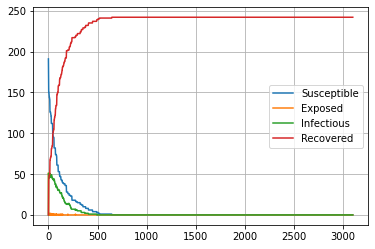

In [ ]:
# Now we're plotting things
listPopulations.rename(columns={1 : "Susceptible", 2: "Exposed", 3: "Infectious", 4: "Recovered"}, inplace=True)
listPopulations.plot()
plt.legend()
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


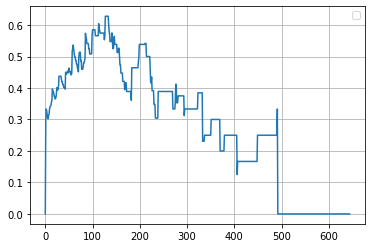

In [ ]:
plt.plot (listPopulations['Infectious']/listPopulations['Susceptible'])
plt.legend()
plt.grid()